<a href="https://colab.research.google.com/github/HyunMooKim/AI-Data/blob/main/Kim_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read me
한양대학교 Jong Soo Kim & Yongil Cho 교수님의 IEEE 논문에 나온
Kim-Monte Carlo 알고리즘 구현

Kim-Monte Carlo algorithm, IEEE Access 7, 79545-79554 (2019)

<br>링크: https://ieeexplore.ieee.org/document/8736872
<br>
<h5>
유튜브에서 AI 관련 영상을 찾다가 우연히 발견한 주식 예측 채널에 어떤 모델을 이용하시는지 질문을 달았다. 알고보니 한양대학교 김종수 교수님이 운영하시는 채널이었고, 직접 개발하신 알고리즘이라고 하셔서 공부해보고 구현해보았다.

</h5>


<h5>

- 임의의 파라미터를 임의의 값으로 업데이트하는 몬테-카를로 방식.

- 전력 예측(간단한 문제) 경우 더 오랜 시간이 걸렸지만, 일반적인 신경망과 비슷한 성능을 내는데는 성공했다.


</h5>


<h5>
 결론:<br>
  임의의 파라미터를 임의의 숫자로 업데이트 하는 방식인데, 전력 예측 문제에서 오차역전파법과 비슷한 성능을 냈다. 다만 시간이 오래 걸린것으로 봐서는 구현을 다른 방식으로 해야하거나 특정 문제에서 더 빠르게 해결되는 듯하다.
</h5>

<h3>
WARNING! : 문서를 보고 직접 구현한 것이라 실제 논문에 쓰인 알고리즘과는 차이가 있습니다. </h3>


# 전력 예측


 일반 DNN의로 test loss 0.002

## Data

In [ ]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
from math import ceil

def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

# Define a function to identify outliers
def is_outlier(value, mean, std_dev, threshold=15): #######################
    return abs(value - mean) > (threshold * std_dev)

#시간을 순환으로 바꾸기 위한 함수. 23시->0시 는 크게 다르지 않다.
def add_cyclic_time_features(df):
    hours_in_day = 24
    df['sin_time'] = np.sin(2 * np.pi * df['time'] / hours_in_day)
    df['cos_time'] = np.cos(2 * np.pi * df['time'] / hours_in_day)
    return df

#여러 시간대 flag
def create_time_flags(df):
    df['meal_time'] = df['time'].apply(lambda x: 1 if (x == 7 or x == 12 or x == 18) else 0)
    df['peak_time9_17'] = df['time'].apply(lambda x: 1 if (9 <= x <= 17) else 0)
    df['peak_time10_19'] = df['time'].apply(lambda x: 1 if (10 <= x <= 19) else 0)
    df['dawn_time'] = df['time'].apply(lambda x: 1 if (0 <= x <= 6) else 0)
    return df

#냉방도시간, 12window size로 측정하는 냉방 수요 지수
def CDH(xs):
    base_temper = 24
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-base_temper))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-base_temper))
    return ys

#공휴일 여부 확인
def is_holiday(date, holiday_list):
    return 1 if (date in holiday_list) else 0
# 공휴일
holidays = ['20220601', '20220606', '20220815',
             '20220604', '20220605',
 '20220611', '20220612', '20220618', '20220619',
 '20220625', '20220626', '20220702', '20220703',
 '20220709', '20220710', '20220716', '20220717',
 '20220723', '20220724', '20220730', '20220731',
 '20220806', '20220807', '20220813', '20220814',
 '20220820', '20220821', '20220827', '20220828']


#건물별 휴무
no_holiday_rules = [ 3,37,38,39,42,61,62,63,64,65,66,67,68,81,86,93,94,95,96,97,98,99,100]
second_4th_sunday = [6,9,87,88,89,90,91,92]
first_3rd_sunday = [12]
dont_need_holiday = [2,4,5,7,8,11,10,13,16,22,32,33,34,35,36,40,54,75,85]


#데이터 불러오기.
train_df = pd.read_csv('train.csv', encoding='cp949')
test_df = pd.read_csv('test.csv', encoding='cp949')
#building_df = pd.read_csv('building_info.csv', encoding='cp949')
#train_df.isna().sum()
#test_df.isna().sum()

'''================= 데이터의 결측치 처리 ==================='''
#test 예측 시에 사용할 수 없는 일조, 일사 열 제거
#train_df = train_df.drop(['일조(hr)','일사(MJ/m2)'], axis=1)
train_df['일조(hr)'].fillna(0.0, inplace=True)
train_df['일사(MJ/m2)'].fillna(0.0, inplace=True)
#매우 많은 강수량 결측값을 0으로 채웁니다
train_df['강수량(mm)'].fillna(0.0, inplace=True)
# 풍속, 습도 결측치 평균으로 채우고 반올림하기
train_df['풍속(m/s)'].fillna(round(train_df['풍속(m/s)'].mean(),2), inplace=True)
train_df['습도(%)'].fillna(round(train_df['습도(%)'].mean(),2), inplace=True)

'''================= 주, 월, 일, 시 나누기 ==================='''
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df['week'] = train_df['일시'].apply(week_of_month)
train_df['date'] =  train_df['일시'].dt.day
train_df['weekday'] = train_df['일시'].dt.weekday
train_df['month'] = train_df['일시'].dt.month
train_df['time'] = train_df['일시'].dt.hour

test_df['일시'] = pd.to_datetime(test_df['일시'])
test_df['week'] = test_df['일시'].apply(week_of_month)
test_df['date'] =  test_df['일시'].dt.day
test_df['weekday'] = test_df['일시'].dt.weekday
test_df['month'] = test_df['일시'].dt.month
test_df['time'] = test_df['일시'].dt.hour

train_df['datetime'] = train_df['일시'].dt.strftime('%Y-%m-%d')
test_df['datetime'] = test_df['일시'].dt.strftime('%Y-%m-%d')

train_df['holiday'] = train_df['일시'].dt.strftime('%Y-%m-%d').apply(lambda x: int(x.replace('-', ''))).apply(lambda x: is_holiday(str(x), holidays))
test_df['holiday'] = test_df['일시'].dt.strftime('%Y-%m-%d').apply(lambda x: int(x.replace('-', ''))).apply(lambda x: is_holiday(str(x), holidays))

#2, 4 번째 일요일 휴무인 건물 존재
train_df['is_2nd_or_4th_sunday'] = 0
second_sundays = (train_df['weekday'] == 6) & (8 <= train_df['date']) & (train_df['date'] <= 14)
fourth_sundays = (train_df['weekday'] == 6) & (22 <= train_df['date']) & (train_df['date'] <= 28)
train_df.loc[second_sundays | fourth_sundays, 'is_2nd_or_4th_sunday'] = 1
test_df['is_2nd_or_4th_sunday'] = 0
second_sundays = (test_df['weekday'] == 6) & (8 <= test_df['date']) & (test_df['date'] <= 14)
fourth_sundays = (test_df['weekday'] == 6) & (22 <= test_df['date']) & (test_df['date'] <= 28)
test_df.loc[second_sundays | fourth_sundays, 'is_2nd_or_4th_sunday'] = 1
#1,3번째 일요일에 휴무인 건물
train_df['is_1st_or_3rd_sunday'] = 0
first_sundays = (train_df['weekday'] == 6) & (1 <= train_df['date']) & (train_df['date'] <= 7)
third_sundays = (train_df['weekday'] == 6) & (15 <= train_df['date']) & (train_df['date'] <= 21)
train_df.loc[first_sundays | third_sundays, 'is_1st_or_3rd_sunday'] = 1
test_df['is_1st_or_3rd_sunday'] = 0
first_sundays = (test_df['weekday'] == 6) & (1 <= test_df['date']) & (test_df['date'] <= 7)
third_sundays = (test_df['weekday'] == 6) & (15 <= test_df['date']) & (test_df['date'] <= 21)
test_df.loc[first_sundays | third_sundays, 'is_1st_or_3rd_sunday'] = 1

#여러 시간대 flag
train_df = create_time_flags(train_df)
test_df = create_time_flags(test_df)

# 시간을 순환하도록
train_df = add_cyclic_time_features(train_df)
train_df['sin_date'] = np.sin(2 * np.pi * (train_df['month']+train_df['date']/31)/12)
train_df['cos_date'] = np.cos(2 * np.pi * (train_df['month']+train_df['date']/31)/12)
train_df['sin_weekday'] = np.sin(2 * np.pi * (train_df['weekday']+1)/7.0)
train_df['cos_weekday'] = np.cos(2 * np.pi * (train_df['weekday']+1)/7.0)
test_df = add_cyclic_time_features(test_df)
test_df['sin_date'] = np.sin(2 * np.pi * (test_df['month']+test_df['date']/31)/12)
test_df['cos_date'] = np.cos(2 * np.pi * (test_df['month']+test_df['date']/31)/12)
test_df['sin_weekday'] = np.sin(2 * np.pi * (test_df['weekday']+1)/7.0)
test_df['cos_weekday'] = np.cos(2 * np.pi * (test_df['weekday']+1)/7.0)

'''================= 건물 정보 합치기 ==================='''
#건물 정보
'''
train_df = pd.merge(train_df, building_df, on='건물번호', how='left')
test_df = pd.merge(test_df, building_df, on='건물번호', how= 'left')
# Replace '-' values with 0
train_df['태양광용량(kW)'] = train_df['태양광용량(kW)'].replace('-', 0)
train_df['ESS저장용량(kWh)'] = train_df['ESS저장용량(kWh)'].replace('-', 0)
train_df['PCS용량(kW)'] = train_df['PCS용량(kW)'].replace('-', 0)
test_df['태양광용량(kW)'] = test_df['태양광용량(kW)'].replace('-', 0)
test_df['ESS저장용량(kWh)'] = test_df['ESS저장용량(kWh)'].replace('-', 0)
test_df['PCS용량(kW)'] = test_df['PCS용량(kW)'].replace('-', 0)

train_df['태양광용량(kW)'] = train_df['태양광용량(kW)'].astype(float)
train_df['ESS저장용량(kWh)'] = train_df['ESS저장용량(kWh)'].astype(float)
train_df['PCS용량(kW)'] = train_df['PCS용량(kW)'].astype(float)
test_df['태양광용량(kW)'] = test_df['태양광용량(kW)'].astype(float)
test_df['ESS저장용량(kWh)'] = test_df['ESS저장용량(kWh)'].astype(float)
test_df['PCS용량(kW)'] = test_df['PCS용량(kW)'].astype(float)
'''

'''================= 각각 건물로 Train 데이터 나누기 ==================='''
'''================= train과 test에 모두 featuring 진행 ==================='''
train_dfs = {}
for building_number in range(1,101):
    train_dfs[building_number] = train_df[train_df['건물번호'] == building_number]
    #요일별 평균
    train_dfs[building_number]['weekday_hour_average'] = train_dfs[building_number].groupby(['weekday', 'time'])['전력소비량(kWh)'].transform('mean')
    #month_weekday_hour average
    train_dfs[building_number]['month_weekday_hour_average'] = train_dfs[building_number].groupby(['month', 'weekday', 'time'])['전력소비량(kWh)'].transform('mean')
    #month_weekday_hour std
    train_dfs[building_number]['month_weekday_hour_std'] = train_dfs[building_number].groupby(['month', 'weekday', 'time'])['전력소비량(kWh)'].transform('std')
    #week_weekday_hour average -몇 번째 주, 무슨 요일별 휴무가 있으니
    train_dfs[building_number]['week_weekday_hour_average'] = train_dfs[building_number].groupby(['week', 'weekday', 'time'])['전력소비량(kWh)'].transform('mean')
    #후보정을 위한 week_weekday_day min
    train_dfs[building_number]['week_weekday_hour_min'] = train_dfs[building_number].groupby(['week', 'weekday', 'time'])['전력소비량(kWh)'].transform('min')
    #CDH
    cdh = CDH(train_dfs[building_number]['기온(C)'].values)
    train_dfs[building_number]['CDH'] = cdh
    # THI - 불쾌지수
    train_dfs[building_number]['THI'] = (
        9 / 5 * train_dfs[building_number]['기온(C)']
        - 0.55 * (1 - train_dfs[building_number]['습도(%)'] / 100)
        * (9 / 5 * train_dfs[building_number]['기온(C)'] - 26) + 32
    )
    '''
    train_dfs[building_number].loc[train_dfs[building_number]['THI'] < 68, 'THI'] = 0
    train_dfs[building_number].loc[(train_dfs[building_number]['THI'] >= 68) & (train_dfs[building_number]['THI'] < 75), 'THI'] = 1
    train_dfs[building_number].loc[(train_dfs[building_number]['THI'] >= 75) & (train_dfs[building_number]['THI'] < 80), 'THI'] = 2
    train_dfs[building_number].loc[train_dfs[building_number]['THI'] >= 80, 'THI'] = 3
    '''
    # 체감 온도
    train_dfs[building_number]['s-temperature'] = (
    13.12
    + 0.6215 * train_dfs[building_number]['기온(C)']
    - 11.37 * (train_dfs[building_number]['풍속(m/s)'] * 3.6) ** 0.16
    + 0.3965 * (train_dfs[building_number]['풍속(m/s)'] * 3.6) ** 0.16 * train_dfs[building_number]['기온(C)']
    )
    #미분
    '''
    train_dfs[building_number]['기온(C)'] = train_dfs[building_number]['기온(C)'].diff()
    train_dfs[building_number]['풍속(m/s)'] = train_dfs[building_number][	'풍속(m/s)'].diff()
    train_dfs[building_number]['습도(%)'] = train_dfs[building_number]['습도(%)'].diff()
    train_dfs[building_number]['CDH'] = train_dfs[building_number]['CDH'].diff()
    train_dfs[building_number]['THI'] = train_dfs[building_number]['THI'].diff()
    train_dfs[building_number]['s-temperature'] = train_dfs[building_number]['s-temperature'].diff()
    train_dfs[building_number] = train_dfs[building_number].dropna()
    '''
    '''
     # 이상치 한 두개 제거
    if(building_number == 34):
        condition = train_dfs[building_number]['num_date_time'] == '34_20220808 21'
        train_dfs[building_number].loc[condition, '전력소비량(kWh)'] = train_dfs[building_number].loc[condition, 'weekday_hour_average']
    if(building_number == 56):
        condition = train_dfs[building_number]['num_date_time'] == '56_20220608 16'
        train_dfs[building_number].loc[condition, '전력소비량(kWh)'] = train_dfs[building_number].loc[condition, 'weekday_hour_average']
    if(building_number == 75):
        condition = train_dfs[building_number]['num_date_time'] == '75_20220730 17'
        train_dfs[building_number].loc[condition, '전력소비량(kWh)'] = train_dfs[building_number].loc[condition, 'weekday_hour_average']
    #이상치가 한 두개가 아니라 대체 할 수 없을 경우 그 구간을 빼준다.
    if building_number == 70:
        start_date = '2022-07-29'
        end_date = '2022-08-08'
        mask = ~((train_dfs[building_number]['일시'] >= start_date) & (train_dfs[building_number]['일시'] <= end_date))
        filtered_data = train_dfs[building_number][mask]
    if building_number == 7:
        start_date = '2022-07-05'
        mask = ((train_dfs[building_number]['일시'] >= start_date))
        filtered_data = train_dfs[building_number][mask]
    if building_number == 75:
        start_date = '2022-07-01'
        mask = ((train_dfs[building_number]['일시'] >= start_date))
        filtered_data = train_dfs[building_number][mask]
    '''



#TEST 에도 같은 featuring 작업을 해준다.
test_dfs = {}
for building_number in range(1, 101):
    test_dfs[building_number] = test_df[test_df['건물번호'] == building_number]
    #month_hour average - train_dfs 에서 8월 정보를 가져온다.
    tmp = train_dfs[building_number][(train_dfs[building_number]['month'] == 8)][['건물번호', 'weekday', 'time', 'month_weekday_hour_average']].drop_duplicates()
    test_dfs[building_number] = test_dfs[building_number].merge(tmp, on=['건물번호', 'weekday', 'time'], how='left')
    #month_hour std
    tmp = train_dfs[building_number][(train_dfs[building_number]['month'] == 8)][['건물번호', 'weekday', 'time', 'month_weekday_hour_std']].drop_duplicates()
    test_dfs[building_number] = test_dfs[building_number].merge(tmp, on=['건물번호', 'weekday', 'time'], how='left')
    #week_weekday_hour average
    tmp = train_dfs[building_number][ ['week', 'weekday', 'time', 'week_weekday_hour_average'] ].drop_duplicates()
    test_dfs[building_number] = test_dfs[building_number].merge(tmp, on=['week', 'weekday', 'time'], how='left')
    #요일별 평균
    tmp = train_dfs[building_number][ ['weekday', 'time', 'weekday_hour_average'] ].drop_duplicates()
    test_dfs[building_number] = test_dfs[building_number].merge(tmp, on=['weekday', 'time'], how='left')

    #후보정 week_weekday_hour_min
    tmp = train_dfs[building_number][ ['week', 'weekday', 'time', 'week_weekday_hour_min'] ].drop_duplicates()
    test_dfs[building_number] = test_dfs[building_number].merge(tmp, on=['week', 'weekday', 'time'], how='left')
    # CDH
    cdh = CDH(test_dfs[building_number]['기온(C)'].values)
    test_dfs[building_number]['CDH'] = cdh
    # THI - 불쾌지수
    test_dfs[building_number]['THI'] = (
        9 / 5 * test_dfs[building_number]['기온(C)']
        - 0.55 * (1 - test_dfs[building_number]['습도(%)'] / 100)
        * (9 / 5 * test_dfs[building_number]['기온(C)'] - 26) + 32
    )
    '''
    test_dfs[building_number].loc[test_dfs[building_number]['THI'] < 68, 'THI'] = 0
    test_dfs[building_number].loc[(test_dfs[building_number]['THI'] >= 68) & (test_dfs[building_number]['THI'] < 75), 'THI'] = 1
    test_dfs[building_number].loc[(test_dfs[building_number]['THI'] >= 75) & (test_dfs[building_number]['THI'] < 80), 'THI'] = 2
    test_dfs[building_number].loc[test_dfs[building_number]['THI'] >= 80, 'THI'] = 3
    '''
    #체감온도
    test_dfs[building_number]['s-temperature'] = (
    13.12
    + 0.6215 * test_dfs[building_number]['기온(C)']
    - 11.37 * (test_dfs[building_number]['풍속(m/s)'] * 3.6) ** 0.16
    + 0.3965 * (test_dfs[building_number]['풍속(m/s)'] * 3.6) ** 0.16 * test_dfs[building_number]['기온(C)']
    )
    #미분
    '''
    #기온 미분으로 첫 행이 없어지므로 하나 붙여준다.
    last_rows_train =  train_dfs[building_number].tail(1)
    last_rows_train = last_rows_train[test_df.columns]
    test_dfs[building_number] = pd.concat([last_rows_train, test_dfs[building_number]], ignore_index=True)

    test_dfs[building_number]['기온(C)'] = test_dfs[building_number]['기온(C)'].diff()
    test_dfs[building_number][	'풍속(m/s)'] = test_dfs[building_number][	'풍속(m/s)'].diff()
    test_dfs[building_number]['습도(%)'] = test_dfs[building_number]['습도(%)'].diff()
    test_dfs[building_number]['CDH'] = test_dfs[building_number]['CDH'].diff()
    test_dfs[building_number]['THI'] = test_dfs[building_number]['THI'].diff()
    test_dfs[building_number]['s-temperature'] = test_dfs[building_number]['s-temperature'].diff()

    test_dfs[building_number] = test_dfs[building_number].dropna()
    '''




test_dfs[1]

<ipython-input-2-6a3e98335f37>:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dfs[building_number]['weekday_hour_average'] = train_dfs[building_number].groupby(['weekday', 'time'])['전력소비량(kWh)'].transform('mean')
<ipython-input-2-6a3e98335f37>:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dfs[building_number]['month_weekday_hour_average'] = train_dfs[building_number].groupby(['month', 'weekday', 'time'])['전력소비량(kWh)'].transform('mean')
<ipython-input-2-6a3e98335f37>:169: SettingWithCopy

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),week,date,weekday,...,sin_weekday,cos_weekday,month_weekday_hour_average,month_weekday_hour_std,week_weekday_hour_average,weekday_hour_average,week_weekday_hour_min,CDH,THI,s-temperature
0,1_20220825 00,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,4,25,3,...,-0.433884,-0.900969,1914.40,127.192151,1534.80,1627.800000,1132.32,-0.5,71.78980,24.867486
1,1_20220825 01,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,4,25,3,...,-0.433884,-0.900969,1845.76,131.129054,1461.84,1550.080000,1056.00,-1.5,71.02840,24.698272
2,1_20220825 02,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,4,25,3,...,-0.433884,-0.900969,1695.04,121.674398,1320.72,1431.120000,969.12,-2.8,70.81675,24.124701
3,1_20220825 03,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,4,25,3,...,-0.433884,-0.900969,1622.72,112.621476,1268.40,1372.200000,952.80,-4.7,70.11262,23.517516
4,1_20220825 04,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,4,25,3,...,-0.433884,-0.900969,1622.24,107.342353,1292.40,1381.720000,984.00,-6.9,69.56514,23.322268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1_20220831 19,1,2022-08-31 19:00:00,23.5,0.0,2.0,75,5,31,2,...,0.433884,-0.900969,2748.96,319.240779,2820.00,2571.470769,2760.96,-12.5,72.05875,24.910736
164,1_20220831 20,1,2022-08-31 20:00:00,22.4,0.0,2.0,80,5,31,2,...,0.433884,-0.900969,2586.00,503.499409,2526.48,2391.027692,2508.48,-10.0,70.74480,23.628937
165,1_20220831 21,1,2022-08-31 21:00:00,21.7,0.0,1.6,81,5,31,2,...,0.433884,-0.900969,2014.32,220.166221,1918.08,1887.950769,1748.16,-8.6,69.69523,22.946290
166,1_20220831 22,1,2022-08-31 22:00:00,21.1,0.0,1.0,83,5,31,2,...,0.433884,-0.900969,1431.84,38.233640,1482.48,1412.861538,1408.32,-9.0,68.85987,22.546535


## DNN

Epoch 1/100
51/51 [==============================] - 1s 5ms/step - loss: 0.0425 - val_loss: 0.0342
Epoch 2/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0114 - val_loss: 0.0183
Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0145
Epoch 4/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0137
Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0122
Epoch 6/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0108
Epoch 7/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0105
Epoch 8/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0099
Epoch 9/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0101
Epoch 10/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0100
Epoch 11/

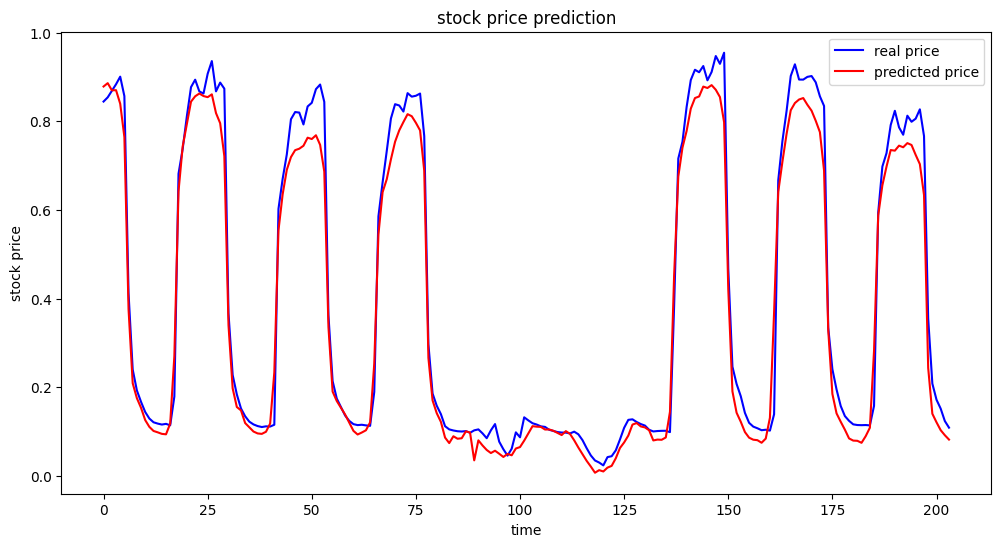

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random

def MinMaxScaler(data):
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  return numerator / (denominator+1e-7) #0으로 나누지 않도록 작은 값 추가

# Define the model
def create_model(input_shape, hidden_units, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=hidden_units, input_shape=input_shape,activation='relu',
                              kernel_initializer=tf.initializers.RandomUniform(minval=-X, maxval=X)),
        tf.keras.layers.Dense(units=output_dim, activation='relu',
                              kernel_initializer=tf.initializers.RandomUniform(minval=-X, maxval=X))
    ])
    return model


'''======================= Data ======================='''
building_number = 20
all_features = ['강수량(mm)', '풍속(m/s)','습도(%)', '기온(C)', 'month','week','weekday', 'sin_time', 'cos_time' ,
                 'holiday', 'CDH' ,'THI','s-temperature','week_weekday_hour_average']

num_features = len(all_features)
data_x = train_dfs[building_number][ all_features ]
data_y = train_dfs[building_number][['전력소비량(kWh)']]
input_dim =  (None,num_features)


data_x_scaled_2d = MinMaxScaler(data_x)
data_y = MinMaxScaler(data_y)
x_train, x_test, y_train, y_test = train_test_split(data_x_scaled_2d, data_y, random_state=66, test_size= 0.2, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_test , y_test, random_state=66, test_size= 0.5, shuffle=False)

x_train = np.array(x_train).reshape(-1, num_features)
x_test = np.array(x_test).reshape(-1,num_features)
x_val = np.array(x_val).reshape(-1,num_features)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

'''======================= HyperParameters ======================='''

hidden_units =  32
output_dim =  1

'''======================= Model ======================='''
# Initailize model
model = create_model(input_dim, hidden_units, output_dim)
# model.build(input_dim)
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(x_val, y_val),
                    shuffle=True)

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores)


# predict
y_pred = model.predict(x_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='real price')
plt.plot(y_pred ,color='red', label='predicted price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

## Kim-Monte Carlo
new loss:  tf.Tensor(0.0023235595, shape=(), dtype=float32)
val loss:  tf.Tensor(0.0041091745, shape=(), dtype=float32)
-- 그때 hyper


-nobatch no bias
hidden_units =  32
output_dim =  1
X = 0.2  #0.2 : initial weights
Y = 0.1  #0.1 : weight updating value
P = 0.07  # 0.15 :  selecting ratio , loop가 진행될수록 파라미터를 조금씩 뽑는다.
R = 15 # 30 :
S = 1  #9 :P/L 만큼이 S에 도달하면 다음 loop
L = 10 #10 : loop 횟수


1번째 loop
--------------- updated ---------------
new loss:  tf.Tensor(0.17356068, shape=(), dtype=float32)
--------------- updated ---------------
new loss:  tf.Tensor(0.12573834, shape=(), dtype=float32)
--------------- updated ---------------
new loss:  tf.Tensor(0.09802084, shape=(), dtype=float32)
--------------- updated ---------------
new loss:  tf.Tensor(0.090499595, shape=(), dtype=float32)
--------------- updated ---------------
new loss:  tf.Tensor(0.08029493, shape=(), dtype=float32)
--------------- updated ---------------
new loss:  tf.Tensor(0.07404734, shape=(), dtype=float32)
--------------- updated ---------------
new loss:  tf.Tensor(0.067826696, shape=(), dtype=float32)
--------------- updated ---------------
new loss:  tf.Tensor(0.057618067, shape=(), dtype=float32)
--------------- updated ---------------
new loss:  tf.Tensor(0.04507094, shape=(), dtype=float32)
--------------- updated ---------------
new loss:  tf.Tensor(0.044430535, shape=(), dtype=float32)
-------

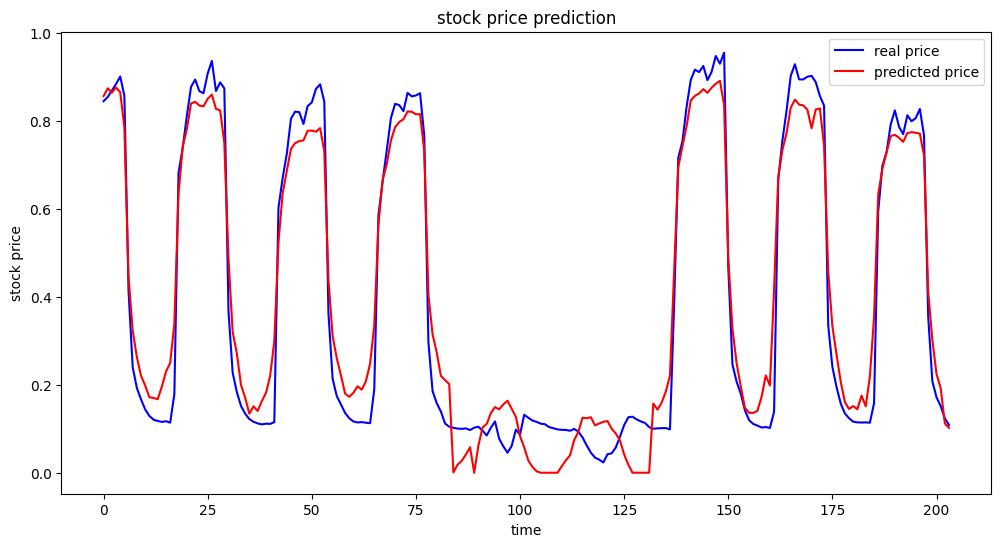

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

def MinMaxScaler(data):
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  return numerator / (denominator+1e-7) #0으로 나누지 않도록 작은 값 추가


# Define the model
def create_model(input_shape, hidden_units, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=hidden_units, input_shape=input_shape,activation='relu',
                              kernel_initializer=tf.initializers.RandomUniform(minval=-X, maxval=X)),
        tf.keras.layers.Dense(units=output_dim, activation='relu',
                              kernel_initializer=tf.initializers.RandomUniform(minval=-X, maxval=X))
    ])
    return model

# Define the Kim-Monte Carlo algorithm
def kim_monte_carlo_algorithm(model, x_train, y_train, x_val, y_val, Y, P, R, S, L):
    # 비교를 위한 초기화
    new_model = tf.keras.models.clone_model(model)
    f = 0 # flag - who is the best now? 0 for model, 1 for new_model
    best_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_train, model.predict(x_train, verbose = False )))

    # original parameters
    weights = model.get_weights()
    # make it flat - 그래야 동일한 확률로 접근한다! [layer][index] 이렇게 2D로 접근하면 확률이 다르다.
    flattened_weights_biases = []
    shapes = []
    bias_indices = []
    for i, weight_matrix in enumerate(weights):
        shapes.append((i, weight_matrix.shape))
        is_bias = i % 2 == 1
        for j, param in enumerate(weight_matrix.flatten()):
            flat_index = len(flattened_weights_biases) + j
            # bias index기록
            if is_bias:
                bias_indices.append(flat_index)
            flattened_weights_biases.append(param)

    for l in range(1, L + 1):
        #Step B
        p = P / l
        s = 0
        # annealing = Y/l
        print(f'{l}번째 loop')
        while s < S: #S는 총 변화 허용 %
            #Step C
            num_selected = round( len(flattened_weights_biases)  * p)
            selected_indices = np.random.choice(len(flattened_weights_biases), num_selected, replace=False) #정해진 개수를 뽑는다
            s += p # 변화 시도 만큼 기록
            #Step D
            for r in range(R):
                #random 값으로 업데이트
                tmporal_flattened_weights_biases = np.copy(flattened_weights_biases)
                random_values = np.random.uniform(-Y, Y, size=num_selected)
                tmporal_flattened_weights_biases = np.array(tmporal_flattened_weights_biases)
                tmporal_flattened_weights_biases[selected_indices] += random_values

                # bias 음수 방지
                for index in selected_indices:
                    #bias가 음수면 양수로
                    if (index in bias_indices) and (tmporal_flattened_weights_biases[index] < 0):
                        tmporal_flattened_weights_biases[index] = abs(tmporal_flattened_weights_biases[index])
                        r += 1


                #Step E - 업데이트가 가치 있다면 반영한다.
                # 평면에서 다시 2D로 만든다.
                new_weights = []
                start_index = 0
                for i, shape in shapes:
                    size = np.product(shape)
                    new_weight_matrix_flat = tmporal_flattened_weights_biases[start_index:start_index+size]
                    new_weight_matrix_reshaped = np.reshape(new_weight_matrix_flat, newshape=shape)
                    new_weights.append(new_weight_matrix_reshaped)
                    start_index += size

                # you can try with batch
                # batch_size = len(x_train) // 2
                # start = random.randint(0, len(x_train) - batch_size)
                # new_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_train[i:i+batch_size], model.predict(x_train[i:i+batch_size], verbose = False )))

                # best 아닌 모델에 새로운 시도
                if f == 0:
                    new_model.set_weights(new_weights)
                    new_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_train, new_model.predict(x_train, verbose = False )))
                    # val_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_val, new_model.predict(x_val, verbose = False )))
                else:
                    model.set_weights(new_weights)
                    new_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_train, model.predict(x_train, verbose = False )))
                    # val_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_val, model.predict(x_val, verbose = False )))

                if new_loss < best_loss:
                    print('--------------- updated ---------------')
                    best_loss =  new_loss
                    print('new loss: ', new_loss)
                    flattened_weights_biases = np.copy(tmporal_flattened_weights_biases)


                    # print('val loss: ', val_loss)

                    f = not f


    if(f==0):
        return model

    else:
        return new_model


'''======================= HyperParameters ======================='''

hidden_units =  32
output_dim =  1
X = 0.2  #0.2 : initial weights
Y = 0.1  #0.1 : weight updating value
P = 0.4  # 0.15 :  selecting ratio , loop가 진행될수록 파라미터를 조금씩 뽑는다.
R = 5 # 30 :
S = 1  #9 :P/L 만큼이 S에 도달하면 다음 loop
L = 10 #10 : loop 횟수

'''======================= Data ======================='''
building_number = 20
all_features = ['강수량(mm)', '풍속(m/s)','습도(%)', '기온(C)', 'month','week','weekday', 'sin_time', 'cos_time' ,
                 'holiday', 'CDH' ,'THI','s-temperature','week_weekday_hour_average']

num_features = len(all_features)
data_x = train_dfs[building_number][ all_features ]
data_y = train_dfs[building_number][['전력소비량(kWh)']]
input_dim =  (None,num_features)


data_x_scaled_2d = MinMaxScaler(data_x)
data_y = MinMaxScaler(data_y)
x_train, x_test, y_train, y_test = train_test_split(data_x_scaled_2d, data_y, random_state=66, test_size= 0.2, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_test , y_test, random_state=66, test_size= 0.5, shuffle=False)

x_train = np.array(x_train).reshape(-1, num_features)
x_test = np.array(x_test).reshape(-1,num_features)
x_val = np.array(x_val).reshape(-1,num_features)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

'''======================= Model ======================='''
# Initailize model
model = create_model(input_dim, hidden_units, output_dim)
model.build(input_dim)

# call model
model = kim_monte_carlo_algorithm(model, x_train, y_train, x_val, y_val, Y, P, R, S, L)

model.compile(loss='mean_squared_error', optimizer='adam')
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores)

# predict
y_pred = model.predict(x_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='real price')
plt.plot(y_pred ,color='red', label='predicted price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

flat 안한 버전...

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

def MinMaxScaler(data):
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  return numerator / (denominator+1e-7) #0으로 나누지 않도록 작은 값 추가


# Define the model
def create_model(input_shape, hidden_units, output_dim,X):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=hidden_units, input_shape=input_shape,activation='relu',
                              kernel_initializer=tf.initializers.RandomUniform(minval=-X, maxval=X)),
        tf.keras.layers.Dense(units=output_dim, activation='relu',
                              kernel_initializer=tf.initializers.RandomUniform(minval=-X, maxval=X))
    ])
    return model

# Define the Kim-Monte Carlo algorithm
def kim_monte_carlo_algorithm(model, x_train, y_train, x_val, y_val, Y, P, R, S, L):
    # 비교를 위한 초기화
    new_model = tf.keras.models.clone_model(model)
    f = 0 # flag - who is the best now? 0 for model, 1 for new_model
    best_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_train, model.predict(x_train, verbose = False )))
    # original parameters
    weights = model.get_weights()

    for l in range(1, L + 1):
        #Step B
        p = P / l
        s = 0
        # annealing = Y/l
        print(f'{l}번째 loop')
        while s < S: #S는 총 변화 허용 %
            #Step C
            num_selected = round( len(weights)  * p)
            s += p # 변화 시도 만큼 기록
            #Step D
            for r in range(R):
                #random 값으로 업데이트
                for i, weight_matrix in enumerate(weights):
                    num_weights = weight_matrix.size
                    selected_indices = np.random.choice(num_weights, num_selected, replace=False) #정해진 개수를 뽑는다
                    change_array = np.zeros_like(weight_matrix)
                    change_array.flat[selected_indices] = np.random.uniform(-Y, Y, size=num_selected)
                    weight_matrix += change_array
                    if i % 2 == 1:
                        weight_matrix[selected_indices] = np.abs(weight_matrix[selected_indices])
                        r += 1

                # best 아닌 모델에 새로운 시도
                if f == 0:
                    new_model.set_weights(weights)
                    new_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_train, new_model.predict(x_train, verbose = False )))
                    # val_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_val, new_model.predict(x_val, verbose = False )))
                else:
                    model.set_weights(weights)
                    new_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_train, model.predict(x_train, verbose = False )))
                    # val_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_val, model.predict(x_val, verbose = False )))

                if new_loss < best_loss:
                    print('--------------- updated ---------------')
                    best_loss =  new_loss
                    print('new loss: ', new_loss)
                    # print('val loss: ', val_loss)
                    f = not f
                    if f==0:
                        weights = model.get_weights()
                    else:
                        weights = new_model.get_weights()

    if(f==0):
        return model

    else:
        return new_model


'''======================= HyperParameters ======================='''

hidden_units =  32
output_dim =  1
X = 0.2  #0.2 : initial weights
Y = 0.1  #0.1 : weight updating value
P = 0.1  # 0.15 :  selecting ratio , loop가 진행될수록 파라미터를 조금씩 뽑는다.
R = 5 # 30 :
S = 3  #9 :P/L 만큼이 S에 도달하면 다음 loop
L = 5 #10 : loop 횟수

'''======================= Data ======================='''
building_number = 20
all_features = ['강수량(mm)', '풍속(m/s)','습도(%)', '기온(C)', 'month','week','weekday', 'sin_time', 'cos_time' ,
                 'holiday', 'CDH' ,'THI','s-temperature','week_weekday_hour_average']

num_features = len(all_features)
data_x = train_dfs[building_number][ all_features ]
data_y = train_dfs[building_number][['전력소비량(kWh)']]
input_dim =  (None,num_features)


data_x_scaled_2d = MinMaxScaler(data_x)
data_y = MinMaxScaler(data_y)
x_train, x_test, y_train, y_test = train_test_split(data_x_scaled_2d, data_y, random_state=66, test_size= 0.2, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_test , y_test, random_state=66, test_size= 0.5, shuffle=False)

x_train = np.array(x_train).reshape(-1, num_features)
x_test = np.array(x_test).reshape(-1,num_features)
x_val = np.array(x_val).reshape(-1,num_features)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

'''======================= Model ======================='''
# Initailize model
model = create_model(input_dim, hidden_units, output_dim,X)
model.build(input_dim)

# call model
model = kim_monte_carlo_algorithm(model, x_train, y_train, x_val, y_val, Y, P, R, S, L)

model.compile(loss='mean_squared_error', optimizer='adam')
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores)

# predict
y_pred = model.predict(x_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='real price')
plt.plot(y_pred ,color='red', label='predicted price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

1번째 loop
2번째 loop


KeyboardInterrupt: ignored